<a href="https://colab.research.google.com/github/khodid/2020Evening/blob/master/proj4_VAE_scenery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 처음에 시도했던 배경사진 VAE 재도전

그냥 [proj3](https://github.com/khodid/2020Evening/blob/master/proj3_MNIST_VAE.ipynb)에서 성공시킨 모델 그대로 사용할 거임

## 이미지 Import
1. Colab과 Google Drive 연결
2. dataloader 설정
3. 컴퓨팅 디바이스 설정

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


(-0.5, 63.5, 63.5, -0.5)

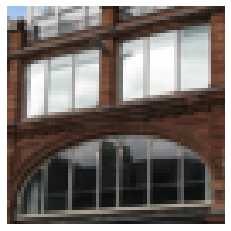

In [2]:
import torchvision
from torchvision import transforms

root = '/content/gdrive/My Drive/Kaggle/scene-classification/train-scene classification/train'

trans= transforms.Compose([
                              transforms.Resize([64, 64]),
                              transforms.ToTensor()
])

train_data = torchvision.datasets.ImageFolder(root = root, transform= trans)

import matplotlib.pyplot as plt
showimg = train_data[10][0].numpy().transpose(1,2,0)

plt.imshow(showimg) # train_data[순서][0: 이미지 / 1: 라벨]
plt.axis('off')

In [3]:
import torch.utils

# dataloader 설정
batch_size = 20
train_set = torch.utils.data.DataLoader(train_data, batch_size= batch_size, shuffle = True, drop_last = True)

In [4]:
# 디바이스 설정
import torch.cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda' : torch.cuda.manual_seed_all(777)

In [5]:
# Checking training data shape
print(type(train_set))
for img, label in train_set:
  break
print(img.shape)

<class 'torch.utils.data.dataloader.DataLoader'>
torch.Size([20, 3, 64, 64])


## 모델 설정
1. 모델 정의(기존 proj3에서 그대로 따옴)
2. 모델 테스트
3. 모델 선언

In [6]:
import torch.nn as nn

class VAE(nn.Module):
  def __init__(self, latent_size):
    super(VAE, self).__init__()
    self.latent_size = latent_size
    self.encoder = nn.Sequential(
                                  # layer 1
                                  nn.Conv2d(3, 16, kernel_size = 5, stride = 1, padding = 2), # 3(64, 64) -> 16(64, 64)
                                  nn.BatchNorm2d(16),
                                  nn.ReLU(),
                                  
                                  #layer 2
                                  nn.Conv2d(16, 32, kernel_size = 5, stride = 2, padding=2), # 16(64, 64) -> 32(32, 32)
                                  nn.BatchNorm2d(32),
                                  nn.ReLU(),

                                  # layer 3
                                  nn. Conv2d(32, 32, kernel_size= 3, stride = 2, padding = 1), # 32(32, 32) -> 32(16, 16)
                                  nn.BatchNorm2d(32),
                                  nn.ReLU(),

                                  # output layer
                                  nn.Flatten()  # 32*16*16 =8,192
    )
    self.fc_mu = nn.Linear(8192, self.latent_size)
    self.fc_logvar = nn.Linear(8192, self.latent_size)
    self.fc_decode = nn.Linear(self.latent_size, 8192)
    self.decoder = nn.Sequential(
                                  # 
                                  # 3-T
                                  nn.ConvTranspose2d(32, 32, kernel_size = 3, stride = 2, padding=1, output_padding=1),
                                  nn.BatchNorm2d(32),
                                  nn.LeakyReLU(),

                                  # 2-T
                                  nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=1),
                                  nn.BatchNorm2d(16),
                                  nn.LeakyReLU(),

                                  # 1-T
                                  nn.ConvTranspose2d(16, 3, kernel_size=5, stride=1, padding=2),
                                  nn.Sigmoid()
    )
  def reparameterize(self, mu, var):
    sigma = torch.exp(0.5*var)
    epsilon = torch.randn_like(sigma)
    return mu + sigma * epsilon

  def encode(self, img):
    h = self.encoder(img)
    mu, log_var = self.fc_mu(h), self.fc_logvar(h)
    z = self.reparameterize(mu, log_var)
    return z, mu, log_var

  def decode(self, z):
    z = self.fc_decode(z)
    new_img = self.decoder(z.view(z.size(0), 32, 16, 16))
    return new_img


====== ENCODER ======
torch.Size([20, 2])
====== DECODER ======
torch.Size([20, 3, 64, 64])


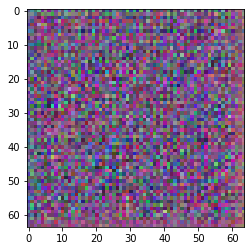

In [7]:
# model test
with torch.no_grad():
  input = torch.randn(20, 3, 64, 64).to(device)
  model = VAE(latent_size = 2).to(device)
  test_z, _, _ = model.encode(input)
  test_out = model.decode(test_z)

  print('====== ENCODER ======')
  print(test_z.shape)
  print('====== DECODER ======')
  print(test_out.shape)

  import matplotlib.pyplot as plt
  if device == 'cuda': test_out = test_out.cpu()
  show = test_out[0].view(3, 64,64).numpy().transpose(1,2,0)
  plt.imshow(show, cmap='gray')

In [8]:
model = VAE(latent_size= 35).to(device)
model.train()

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Flatten()
  )
  (fc_mu): Linear(in_features=8192, out_features=35, bias=True)
  (fc_logvar): Linear(in_features=8192, out_features=35, bias=True)
  (fc_decode): Linear(in_features=35, out_features=8192, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running

## 학습
여기 역시 proj3에서 그대로 따옴

In [9]:
def loss_function(x, target, mu, log_var):
  x, target = x.view(-1,12288), target.view(-1, 12288) # 안 넣으면 오류남
  # r_loss = torch.sqrt(torch.mean(torch.square(target - x)) + 1e-7) # p98 참고 # 0 되는 걸 방지하기 위해
  r_loss = nn.functional.binary_cross_entropy(x, target, reduction='sum')
  kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
  return r_loss, kl_div, r_loss + kl_div

In [10]:
# 진행상황 모니터링용
def compare_img(img, new_img, label, epoch):
  with torch.no_grad():
    if device == 'cuda': img, new_img = img.cpu(), new_img.cpu()
    show_original = img.view(3, 64, 64).numpy().transpose(1,2,0)
    show_gen = new_img.view(3, 64, 64).numpy().transpose(1,2,0)

    plt.subplot(1, 2, 1)
    plt.title('original')
    plt.imshow(show_original, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title('generated')
    plt.imshow(show_gen, cmap = 'gray')
    
    plt.suptitle('Epoch: {} [label-{}]'.format(epoch, label), fontsize=16)
    plt.savefig('VAE_scenery_train_{}.png'.format(epoch))

    plt.clf() # 다음 그림 위해서 비워두기

In [11]:
compare_img(test_out[0],test_out[1],1, 0)

<Figure size 432x288 with 0 Axes>

In [12]:
optimizer = torch.optim.RMSprop(model.parameters(),lr = 0.002)

In [13]:
lenth = len(train_set)

In [15]:
epochs = 50
tick = [0, 5, 8, 10, 15, 20, 30, 50, 100, 120, 150, 180, 200]

model.train(True)

for epoch in range(epochs):
  for idx, (img, label) in enumerate(train_set):
    img = img.to(device)
    
    z, mu, var = model.encode(img)
    new_img = model.decode(z)
    r, k, loss = loss_function(new_img, img, mu, var)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (idx+1) % 200 is 0 : print('Epoch [{}/{}] Step [{}/{}] loss: {} rmse: {}, kl_div: {}'.format(epoch+1, epochs, idx+1, lenth, loss.item(), r.item(), k.item()))
  if epoch in tick : compare_img(img[0], new_img[0], label[0], epoch)
compare_img(img[0], new_img[0], label[0], epoch+1)

RuntimeError: ignored